In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import pickle

import preprocessing as pp
import models as md

from scipy import stats, integrate, optimize

In [2]:
df = pd.read_csv("../data/wholetime.csv")

df = df.dropna()

# データの分割
df_p1 = df[(df['started_at'] >= '2020-03-01') & (df['started_at'] < '2020-06-01')].dropna()
df_p2 = df[(df['started_at'] >= '2020-06-01') & (df['started_at'] < '2020-11-01')].dropna()
df_p3 = df[(df['started_at'] >= '2020-12-01') & (df['started_at'] < '2021-03-01')].dropna()
df_p4 = df[(df['started_at'] >= '2021-03-01') & (df['started_at'] < '2023-10-01')].dropna()
df_p4_1 = df[(df['started_at'] >= '2021-03-01') & (df['started_at'] < '2022-01-01')].dropna()
df_p4_2 = df[(df['started_at'] >= '2022-01-01') & (df['started_at'] < '2023-10-01')].dropna()
df_left = pd.concat([df_p1, df_p2, df_p3, df_p4_1], axis=0)
df_right = pd.concat([df_p4_2], axis=0)

/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_36029/1915566129.py:1: DtypeWarning: Columns (2,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/wholetime.csv")


In [3]:
def return_nm(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    # started_atで昇順にソート
    df = df.sort_values(by='started_at')
    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_list = []
    edge_list = []
    timestamp = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]

        # node_listにはユニークなstart_station_idを追加
        node_list.append(len(df_tmp['start_station_id'].unique()))

        # edge_listにはdf_tmpの行数を追加
        edge_list.append(len(df_tmp))

        current_timestamp = next_timestamp

    # node_listとedge_listで0の値を削除
    node_list = np.array(node_list)
    edge_list = np.array(edge_list)
    timestamp = np.array(timestamp)
    active_node_list = node_list[node_list != 0]
    edge_list = edge_list[edge_list != 0]
    timestamp = timestamp[:len(node_list)]
    
    return active_node_list, edge_list, timestamp

In [4]:
node_left, edge_left, timestamp_left = return_nm(df_left)
node_right, edge_right, timestamp_right = return_nm(df_right)

In [5]:
from scipy import stats, optimize, integrate

In [17]:
def model_beta(x, alpha, beta):
    Np = 744
    # a = np.linspace(0, 1, 1000)
    # f = ((a**(alpha-1)) * ((1-a)**(beta-1)) / stats.beta.rvs(alpha, beta, size=1) ) * (1 - (((alpha + beta) / alpha) * 2*a*x[0])/(Np**2-Np))**(Np - 1)
    f = lambda a: ((a**(alpha-1)) * ((1-a)**(beta-1)) / stats.beta.rvs(alpha, beta, size=1) ) * (1 - (((alpha + beta) / alpha) * 2*a*x[0])/(Np**2-Np))**(Np - 1)
    ff, _ = integrate.quad(f, 0, 1, limit=300000)  # 積分の値と推定誤差を別々に受け取る
    func = Np * (1 - ff) 
    return func

In [18]:
print("+------------------+")
print("| Estimating       |")
print("+------------------+")

params, _ = optimize.curve_fit(model_beta, xdata=edge_right, ydata=node_right, p0=[2, 6])

+------------------+
| Estimating       |
+------------------+


/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_36029/2733007243.py:6: IntegrationWarning: The maximum number of subdivisions (300000) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  ff, _ = integrate.quad(f, 0, 1, limit=300000)  # 積分の値と推定誤差を別々に受け取る
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_36029/2733007243.py:5: RuntimeWarning: overflow encountered in scalar power
  f = lambda a: ((a**(alpha-1)) * ((1-a)**(beta-1)) / stats.beta.rvs(alpha, beta, size=1) ) * (1 - (((alpha + beta) / alpha) * 2*a*x[0])/(Np**2-Np))**(Np - 1)


ValueError: Domain error in arguments. The `scale` parameter must be positive for all distributions, and many distributions have restrictions on shape parameters. Please see the `scipy.stats.beta` documentation for details.

In [184]:
print("alpha: ", params[0])
print("beta: ", params[1])

alpha:  0.2
beta:  6.0


In [185]:
Np = max(node_right)
N = []
for i in range(len(edge_right)):
    f = lambda a: ((a**(params[0]-1)) * ((1-a)**(params[1]-1)) / stats.beta.rvs(params[0], params[1])) * (1 - ((params[0] + params[1]) / params[0]) * ((2 * edge_right[i] * a) / (Np**2 - Np))) ** (Np - 1)
    ff, _ = integrate.quad(f, 0, 1, limit=10000)
    N.append(Np * (1 - ff)) 

/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_33822/1343645223.py:5: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  ff, _ = integrate.quad(f, 0, 1, limit=10000)
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_33822/1343645223.py:5: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  ff, _ = integrate.quad(f, 0, 1, limit=10000)
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_33822/1343645223.py:5: IntegrationWarning: The maximum number of subdivisions (10000) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  prob

In [186]:
plt.figure(figsize=(10, 6))
# plt.scatter(node_left, edge_left, label="left")
plt.scatter(node_right, edge_right, label="right")
plt.plot(node_right, N,label="model", color="orange")
plt.xlabel("N")
plt.ylabel("M")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()


/Users/yiadka/dev/master_ver2/venv/lib/python3.9/site-packages/matplotlib/ticker.py:2392: RuntimeWarning: overflow encountered in power
  ticklocs = b ** decades


OverflowError: cannot convert float infinity to integer

<Figure size 1000x600 with 1 Axes>

In [153]:
# node_rightとedge_rightのデータ
# node_right, edge_rightを正規化する
node_right_nor = node_right - node_right.min() + 1
edge_right_nor = edge_right - edge_right.min() + 2

In [158]:
print("+------------------+")
print("| Estimating       |")
print("+------------------+")

# 初期値をランダムに設定
np.random.seed()
init_alpha = np.random.rand()
init_beta = np.random.rand()

params, _ = optimize.curve_fit(model_beta, xdata=edge_right, ydata=node_right, p0=[5, 5])

+------------------+
| Estimating       |
+------------------+


/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_33822/3553080214.py:4: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  ff, _ = integrate.quad(f, 0, 1)  # 積分の値と推定誤差を別々に受け取る


In [159]:
print("alpha: ", params[0])
print("beta: ", params[1])

alpha:  4.99950669949843
beta:  5.000178389680225


In [160]:
Np = 744
N = []
for i in range(len(edge_right)):
    f = lambda a: ((a**(params[0]-1)) * ((1-a)**(params[1]-1)) / stats.beta(params[0], params[1]).pdf(a)) * (1 - ((params[0] + params[1]) / params[0]) * ((2 * edge_right[i] * a) / (Np**2 - Np))) ** (Np - 1)
    ff, _ = integrate.quad(f, 0, 1, limit=10000)
    N.append(Np * (1 - ff)) 

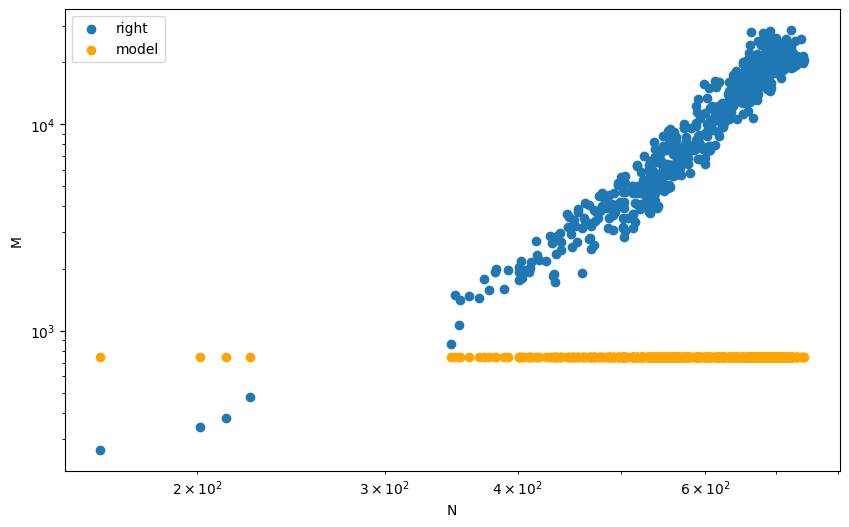

In [162]:
plt.figure(figsize=(10, 6))
# plt.scatter(node_left, edge_left, label="left")
plt.scatter(node_right, edge_right, label="right")
plt.scatter(node_right, N, label="model", color="orange")
plt.xlabel("N")
plt.ylabel("M")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()
